In [1]:
from typing import List, Tuple

In [2]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import spacy
from datasets import load_dataset

c:\Users\kuzga\OneDrive\Рабочий стол\NSU-NLP-labs\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# def load_sib200_ru() -> Tuple[Tuple[List[str], List[int]], Tuple[List[str], List[int]], Tuple[List[str], List[int]], List[str]]:
#     trainset = load_dataset('Davlan/sib200', 'rus_Cyrl', split='train')
#     X_train = trainset['text']
#     y_train = trainset['category']
#     valset = load_dataset('Davlan/sib200', 'rus_Cyrl', split='validation')
#     X_val = valset['text']
#     y_val = valset['category']
#     testset = load_dataset('Davlan/sib200', 'rus_Cyrl', split='test')
#     X_test = testset['text']
#     y_test = testset['category']
#     categories = set(y_train)
#     unknown_categories = set(y_val) - categories
#     if len(unknown_categories) > 0:
#         err_msg = f'The categories {unknown_categories} are represented in the validation set, but they are not represented in the training set.'
#         raise RuntimeError(err_msg)
#     unknown_categories = set(y_test) - categories
#     if len(unknown_categories) > 0:
#         err_msg = f'The categories {unknown_categories} are represented in the test set, but they are not represented in the training set.'
#         raise RuntimeError(err_msg)
#     categories = sorted(list(categories))
#     y_train = [categories.index(it) for it in y_train]
#     y_val = [categories.index(it) for it in y_val]
#     y_test = [categories.index(it) for it in y_test]
#     return (X_train, y_train), (X_val, y_val), (X_test, y_test), categories

In [4]:
def load_sib200_ru() -> Tuple[Tuple[List[str], List[int]], Tuple[List[str], List[int]], List[str]]:
    # Загружаем тренировочный и валидационный наборы данных
    trainset = load_dataset('Davlan/sib200', 'rus_Cyrl', split='train')
    valset = load_dataset('Davlan/sib200', 'rus_Cyrl', split='validation')
    testset = load_dataset('Davlan/sib200', 'rus_Cyrl', split='test')

    # Извлекаем текст и категории
    X_train = trainset['text']
    y_train = trainset['category']
    X_val = valset['text']
    y_val = valset['category']
    X_test = testset['text']
    y_test = testset['category']

    # Объединяем данные из train и val
    X_train = X_train + X_val
    y_train = y_train + y_val

    # Проверяем наличие неизвестных категорий
    categories = set(y_train)
    unknown_categories = set(y_test) - categories
    if len(unknown_categories) > 0:
        err_msg = f'The categories {unknown_categories} are represented in the test set, but they are not represented in the training set.'
        raise RuntimeError(err_msg)

    # Индексируем категории
    categories = sorted(list(categories))
    y_train = [categories.index(it) for it in y_train]
    y_test = [categories.index(it) for it in y_test]

    return (X_train, y_train), (X_test, y_test), categories

In [5]:
def normalize_text(s: str, nlp_pipeline: spacy.Language) -> str:
    doc = nlp_pipeline(s)
    lemmas = [('<NUM>' if token.like_num else token.lemma_.lower()) for token in filter(lambda it1: not it1.is_punct, doc)]
    if len(lemmas) == 0:
        return ''
    return ' '.join(lemmas)

In [6]:
train_data, test_data, classes_list = load_sib200_ru()

In [7]:
print(f'Categories: {classes_list}')

Categories: ['entertainment', 'geography', 'health', 'politics', 'science/technology', 'sports', 'travel']


In [8]:
print(len(train_data[0]))
print(len(test_data[0]))

800
204


In [9]:
nlp = spacy.load('ru_core_news_lg')

In [10]:
print(train_data[0][0])
print(normalize_text(train_data[0][0], nlp))

print(test_data[0][0])
print(normalize_text(test_data[0][0], nlp))

Турция с трёх сторон окружена морями: на западе — Эгейским, на севере — Чёрным и на юге — Средиземным.
турция с <NUM> сторона окружить море на запад эгейский на север чёрным и на юг средиземный
Мутация вносит новую генетическую вариацию, в то время как отбор убирает её из набора проявляющихся вариаций.
мутация вносить новый генетический вариация в тот время как отбор убирать её из набор проявляться вариация


In [16]:
from sklearn.model_selection import train_test_split


X = [normalize_text(it, nlp) for it in train_data[0]]
y = train_data[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(token_pattern='\w+', max_df=0.99, min_df=1)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.neural_network import MLPClassifier

models = {
    'MLPClassifier': MLPClassifier(),
    'LogisticRegression': LogisticRegression(),
    # 'RandomForestClassifier': RandomForestClassifier(),
    # 'AdaBoostClassifier': AdaBoostClassifier(),
    # 'KNeighborsClassifier': KNeighborsClassifier(),
    # 'SVC': SVC(),
    # 'DecisionTreeClassifier': DecisionTreeClassifier(),
}

param_grids = {
    'LogisticRegression': {
        'C': [100, 500, 1000, 1500],  # Regularization strength
        'penalty': ['l1', 'l2', 'elasticnet'],  # Type of regularization
        'solver': ['liblinear', 'lbfgs', 'sag', 'saga'],  # Solver to use
        'max_iter': [100, 200],  # Maximum number of iterations
    },
    'RandomForestClassifier': {
        'n_estimators': [50, 75, 100, 200],
        'max_depth': [None, 2, 5, 10, 15],
        'min_samples_split': [2, 5, 7],
        'min_samples_leaf': [1, 2, 3]
    },
    'AdaBoostClassifier': {
        'n_estimators': [50, 75, 100, 150],
        'learning_rate': [0.075, 0.1, 1]
    },
    'GaussianProcessClassifier': {'max_iter_predict': [100, 200]},
    'GaussianNB': {},
    'KNeighborsClassifier': {
        'n_neighbors': [2, 3, 5, 7, 10],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    'SVC': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    },
    'DecisionTreeClassifier': {
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'MLPClassifier': {
        'hidden_layer_sizes': [(50)],  # Размеры скрытых слоев
        'activation': ['logistic'],  # Функции активации
        'alpha': [0.01],  # Регуляризация L2
        'learning_rate_init': [0.01],  # Начальная скорость обучения
        'max_iter': [500],  # Максимальное количество итераций
        'early_stopping': [True],  # Включение ранней остановки
        'validation_fraction': [0.2],  # Процент валидационной выборки
        'n_iter_no_change': [20]  # Количество эпох без улучшений для остановки
    }
}


logistic_param_options = [
    {'penalty': ['l1'], 'solver': ['liblinear']},
    {'penalty': ['l2'], 'solver': ['lbfgs', 'sag', 'saga']},
    {'penalty': ['elasticnet'], 'solver': ['saga']},
]

# Создаем полный список параметров для LogisticRegression
full_logistic_param_grid = []
for options in logistic_param_options:
    full_logistic_param_grid.append({**options, **param_grids['LogisticRegression']})

# Заменяем параметры LogisticRegression в param_grids на полный список
param_grids['LogisticRegression'] = full_logistic_param_grid

In [18]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
best_models = {}
for model_name, model in models.items():
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        cv=5,
        scoring='f1_macro',
        n_jobs=-1
    )
    grid_search.fit(X_train_vec, y_train)

    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model

    # Оценка на тестовой выборке
    y_pred = best_model.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"Лучшие параметры для {model_name}: {grid_search.best_params_}")
    print(f"f-1 для {model_name}: {f1:.4f} Accuracy: {accuracy:.4f}")

# Шаг 4: Поиск лучшей модели
best_model_name = max(best_models, key=lambda model: f1_score(y_test, best_models[model].predict(X_test_vec), average='macro'))
best_model = best_models[best_model_name]
best_accuracy = accuracy_score(y_test, best_model.predict(X_test_vec))
best_f1 = f1_score(y_test, best_model.predict(X_test_vec), average='macro')

print(f"Лучшая модель: {best_model_name} с Accuracy {best_accuracy:.4f} и f1 {best_f1:.4f}")

Лучшие параметры для MLPClassifier: {'activation': 'logistic', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': 50, 'learning_rate_init': 0.01, 'max_iter': 500, 'n_iter_no_change': 20, 'validation_fraction': 0.2}
f-1 для MLPClassifier: 0.5806 Accuracy: 0.6000
Лучшие параметры для LogisticRegression: {'C': 1500, 'max_iter': 200, 'penalty': 'l2', 'solver': 'saga'}
f-1 для LogisticRegression: 0.6407 Accuracy: 0.6438
Лучшая модель: LogisticRegression с Accuracy 0.6438 и f1 0.6407


In [20]:
y_pred = best_model.predict(X_test_vec)
print(classification_report(y_true=y_test, y_pred=y_pred, target_names=classes_list))

                    precision    recall  f1-score   support

     entertainment       0.55      0.43      0.48        14
         geography       0.89      0.67      0.76        12
            health       0.75      0.41      0.53        22
          politics       0.80      0.80      0.80        25
science/technology       0.61      0.72      0.66        43
            sports       0.81      0.81      0.81        21
            travel       0.39      0.52      0.44        23

          accuracy                           0.64       160
         macro avg       0.68      0.62      0.64       160
      weighted avg       0.67      0.64      0.64       160



орига, на lg модели

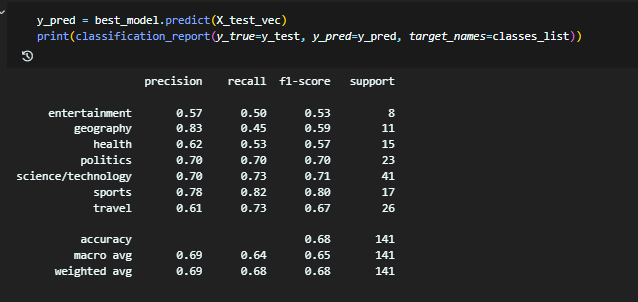

lg + пониженный df

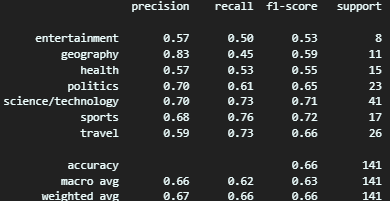

In [22]:
from sklearn.neural_network import MLPClassifier
# def normalize_text(text, nlp_model):
#     doc = nlp_model(text)
#     return ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

def normalize_text(text, nlp_model):
    doc = nlp_model(text)
    return ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

# Load dataset
train_data, val_data, test_data, classes_list = load_sib200_ru()
# label_encoder = LabelEncoder()
# y_train = label_encoder.fit_transform(train_data[1])
# y_test = label_encoder.transform(test_data[1])

# Compute class weights to deal with class imbalance
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Class probability based max_df adjustment
class_probability = 1.0 / len(classes_list)
max_df = 1.0 - 0.2 * class_probability
print(f'Maximal document frequency of term is {max_df}.')

stop_words_list = list(nlp.Defaults.stop_words)


class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}


classifier = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer(token_pattern='\w+', max_df=max_df, min_df=1, ngram_range=(1, 1), max_features=30000)),
    ('cls', MLPClassifier(max_iter=300))  # Base MLP with 1 hidden layer
])

# Grid Search for hyperparameter tuning
cv = GridSearchCV(
    estimator=classifier,
    param_grid={

        'cls__alpha': [0.001, 0.01, 0,1],  # L2 penalty (regularization)
        'cls__learning_rate_init': [ 0.01],  # Initial learning rate
    },
    scoring='f1_macro',  # Optimize for F1 macro to balance precision and recall
    cv=5,
    refit=True,
    n_jobs=-1,
    verbose=True
)


# Training the model

cv.fit([normalize_text(it, nlp) for it in train_data[0]], LE.fit_transform(train_data[1]))
print('Best parameters:')
print(cv.best_params_)

print(cv.best_score_)

# Predictions on the test set
y_pred = cv.predict([normalize_text(it, nlp) for it in test_data[0]])
# vectorizer = TfidfVectorizer()
# vectorizer.fit([normalize_text(it, nlp) for it in train_data[0]])
# print(f'Lenght of dictionary: {len(sorted(vectorizer.vocabulary_))}')


# X = vectorizer.transform([normalize_text(it, nlp) for it in train_data[0]])

LE = LabelEncoder()
y = LE.fit_transform(train_data[1])
# clf = MLPClassifier(random_state=0, alpha=0.1).fit(X, y)


# # test_text_normalized = test_data[0].apply(normalize_text)
# X_test = vectorizer.transform([normalize_text(it, nlp) for it in test_data[0]])
y_test = LE.transform(test_data[1])

# Report performance
print(classification_report(LE.transform(test_data[1]), y_pred, target_names=classes_list))
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
print(f'Scores is \nACC:\nF1M: {f1:.3f}')

ValueError: not enough values to unpack (expected 4, got 3)